# Introducción

Este notebook se centra en cuantificar y comparar la importancia de las variables del conjunto de reclamos de seguros para explicar/predicir la variable objetivo claim_status, como paso siguiente natural al análisis exploratorio (EDA). A partir de la misma versión depurada y transformada del dataset usada en el EDA, aquí se construye un ranking robusto de predictores que permita entender qué dimensiones del cliente, vehículo y póliza aportan más información sobre la ocurrencia de un siniestro.

# Objetivo

Estimar la importancia de cada variable explicativa utilizando enfoques complementarios (Información Mutua, bosques aleatorios balanceados e importancia por permutación) bajo un esquema que respete el fuerte desbalance de clases del target.

Evaluar la estabilidad de dichas importancias mediante bootstrapping y cálculo de intervalos de confianza, priorizando señales consistentes sobre efectos espurios.

Derivar un ranking consolidado de variables clave que sirva tanto para interpretar el fenómeno de siniestralidad como para guiar la selección de features en los modelos predictivos posteriores.


# Metodología

Preparación de datos: se parte del mismo dataframe del EDA realizando transformaciones a variables(extracción de métricas de motor desde maxtorque y maxpower, codificación de variables categóricas como regioncode, fuel_type, transmission_type, segment, y binarización de las variables de equipamiento de seguridad), eliminando identificadores como policyid y separando X (features) de y = claim_status.

Información Mutua con bootstrapping: se calcula la información mutua entre cada feature y claim_status sobre múltiples muestras bootstrap estratificadas que balancean la clase minoritaria en cada iteración, obteniendo como salida la media, mediana, desviación estándar e intervalos de confianza de la importancia por información mutua para cada variable.

Importancia en Balanced Random Forest: se entrena un BalancedRandomForestClassifier (imblearn) sobre un conjunto balanceado de observaciones para capturar relaciones no lineales e interacciones, extrayendo la importancia promedio de cada feature a partir de la reducción de impureza en los árboles (MDI) y registrando su distribución.

Importancia por permutación: sobre el modelo balanceado ya entrenado, se calcula la caída en desempeño (ROC-AUC) ante permutaciones controladas de cada variable, aplicando también re-muestreo para estabilizar las estimaciones y obtener un ranking alternativo basado en sensibilidad del modelo.

Consolidación y visualización: se integran las tres fuentes de importancia en un único dataframe, se ordenan las variables por su contribución relativa y se generan gráficos de barras con intervalos de confianza para resaltar los predictores más influyentes y contrastar la coherencia de los métodos con los patrones encontrados en el EDA.

# Inatlación e importación de librerías

In [1]:
!pip install -r requirements.txt -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 MB 10.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from tqdm import tqdm
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import plotly.io as pio
pio.renderers.default = "png"

# Importación y transformación de datos

In [3]:
from Utils import extraer_motor_metricas, get_encoding, binarizar_columnas,\
 calcular_mi_bootstrap_profundo, calcular_importancia_brf, calcular_permutacion_segura, consolidar_importancias

In [4]:
datos = pd.read_csv('/content/Claims Dataset.csv', sep=';')
df = datos.copy()

In [5]:
df = extraer_motor_metricas(df, 'max_torque', 'max_torque_nm', 'max_torque_rpm')
df = extraer_motor_metricas(df, 'max_power', 'max_power_bhp', 'max_power_rpm')
#

In [6]:
df = get_encoding(df,"region_code")
df = get_encoding(df,"fuel_type")
df = get_encoding(df,"transmission_type")
df = get_encoding(df,"steering_type")
df = get_encoding(df,"rear_brakes_type")
df = get_encoding(df,"model")
df = get_encoding(df,"engine_type")
df = get_encoding(df,"segment")


In [7]:
columns = ['is_esc',	'is_adjustable_steering',	'is_tpms',	'is_parking_sensors',	'is_parking_camera',
           'is_front_fog_lights',	'is_rear_window_wiper',	'is_rear_window_washer',	'is_rear_window_defogger',
           'is_brake_assist',	'is_power_door_locks',	'is_central_locking',	'is_power_steering',
           'is_driver_seat_height_adjustable',	'is_day_night_rear_view_mirror',	'is_ecw',	'is_speed_alert'
]

df = binarizar_columnas(df, columns)

# Calculando Información Mutua

In [8]:
# Separando en features y target
X = df[[i for i in df.columns if i != "policy_id"]].copy()
y = X.pop("claim_status")

--- Iniciando Bootstrapping Profundo (200 ciclos) ---
Clase Minoritaria: 3748 casos por iteración.
Total procesado por ciclo: 7496 filas.


Calculando MI: 100%|██████████| 200/200 [01:34<00:00,  2.13it/s]


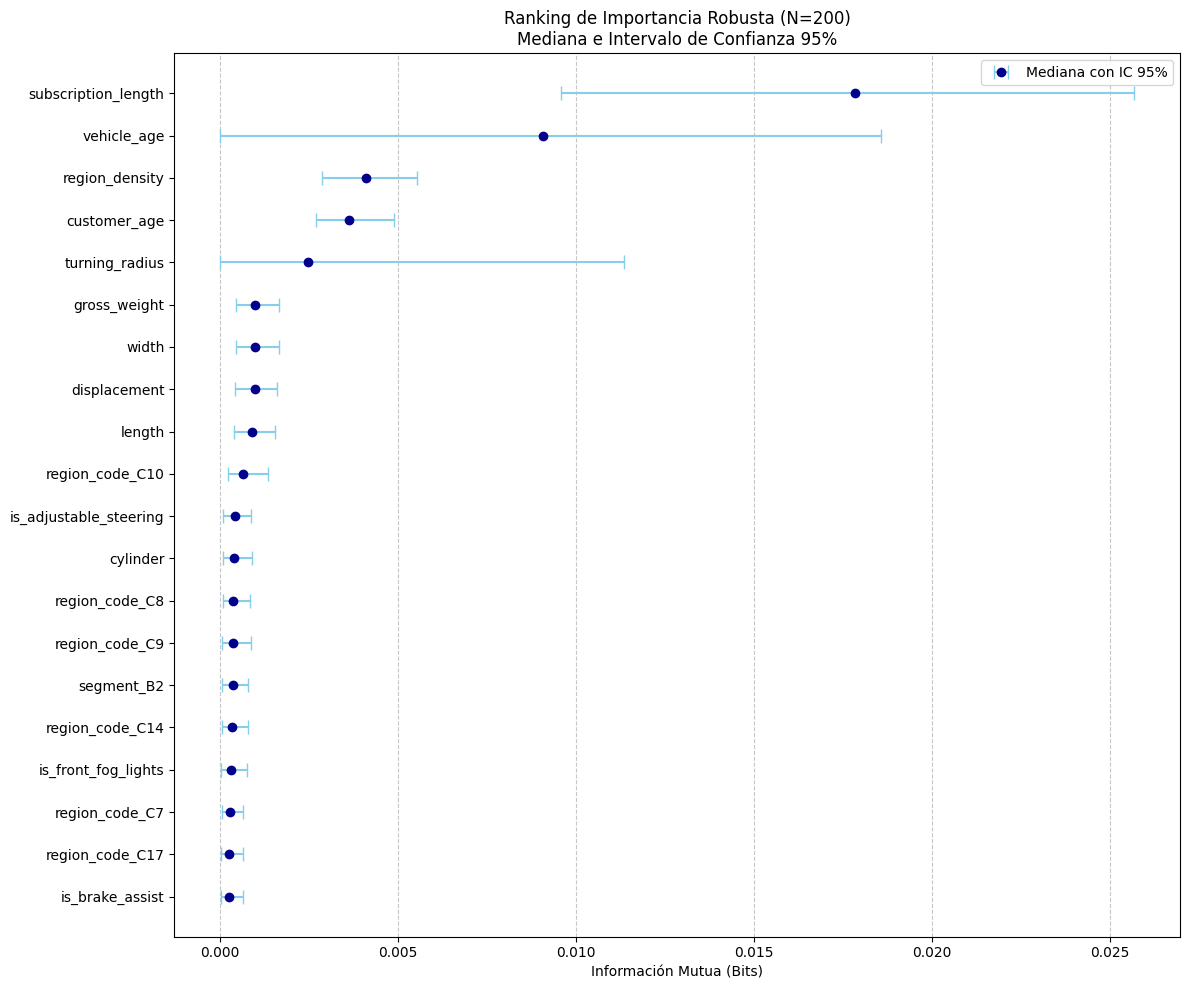

,MI_Mean,MI_Median,MI_Std,CI_Lower,CI_Upper
subscription_length,0.017933,0.017825,0.004474,9.572488e-03,0.025683
vehicle_age,0.009020,0.009068,0.004830,0.000000e+00,0.018565
region_density,0.004127,0.004091,0.000684,2.857877e-03,0.005529
customer_age,0.003662,0.003626,0.000574,2.694121e-03,0.004886
turning_radius,0.003182,0.002480,0.003484,0.000000e+00,0.011351
...,...,...,...,...,...
region_code_C6,0.000032,0.000010,0.000044,1.776357e-15,0.000138
max_torque_nm,0.000076,0.000000,0.000476,0.000000e+00,0.000681
max_torque_rpm,0.000502,0.000000,0.001335,0.000000e+00,0.005146
max_power_bhp,0.000190,0.000000,0.000819,0.000000e+00,0.002584


In [9]:
calcular_mi_bootstrap_profundo(X,y, n_iteraciones=200)

# Calculando Random forest e impureza de Gini

Entrenando Balanced Random Forest sobre (58592, 93)...


/content/Utils.py:224: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




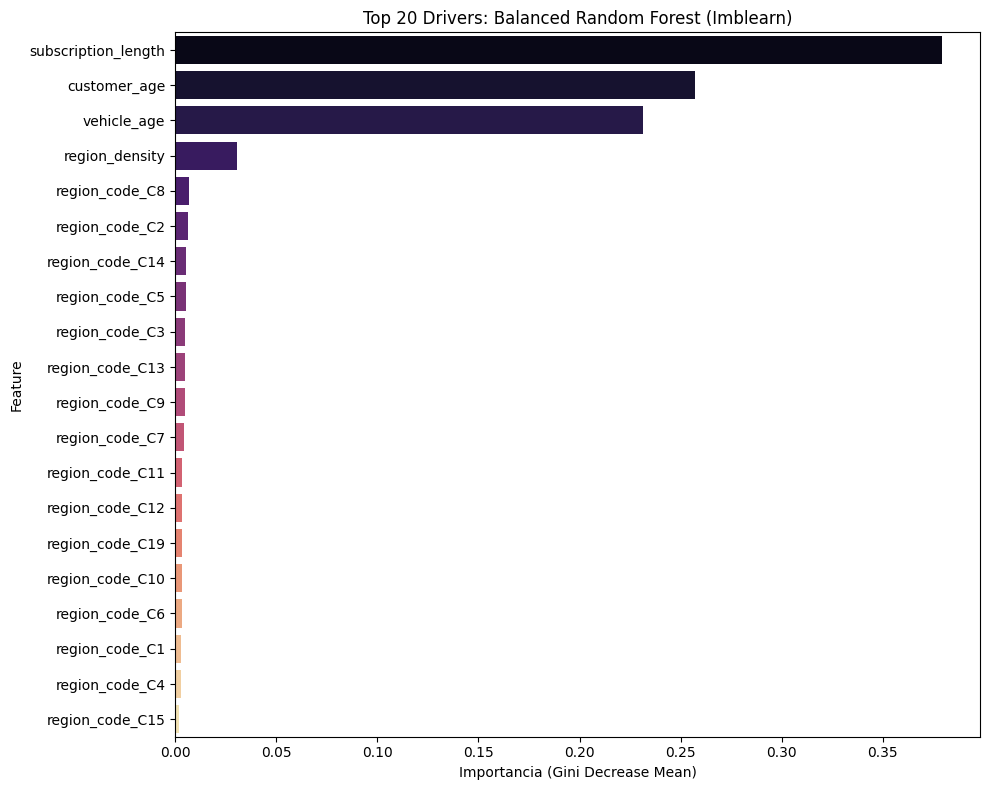

In [10]:
df_importancia = calcular_importancia_brf(X,y)

# Calculando Análisis de permutación

In [11]:
model = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [12]:
df_permutation_results = calcular_permutacion_segura(model, X, y)

Verificando modelo...
Entrenando modelo (BalancedRandomForest)...
Calculando línea base...
Baseline ROC-AUC: 0.9879
Iniciando evaluación de 93 variables...


100%|██████████| 93/93 [08:35<00:00,  5.54s/it]


In [13]:
prefixes = [
    'region_code_', 'fuel_type_', 'transmission_type_',
    'steering_type_', 'rear_brakes_type_', 'model_',
    'engine_type_', 'segment_'
]

In [14]:
df_permutation_results_final = consolidar_importancias(df_permutation_results,prefixes)

In [15]:
df_permutation_results_final.columns = ["Variable","Importancia_total","Std"]

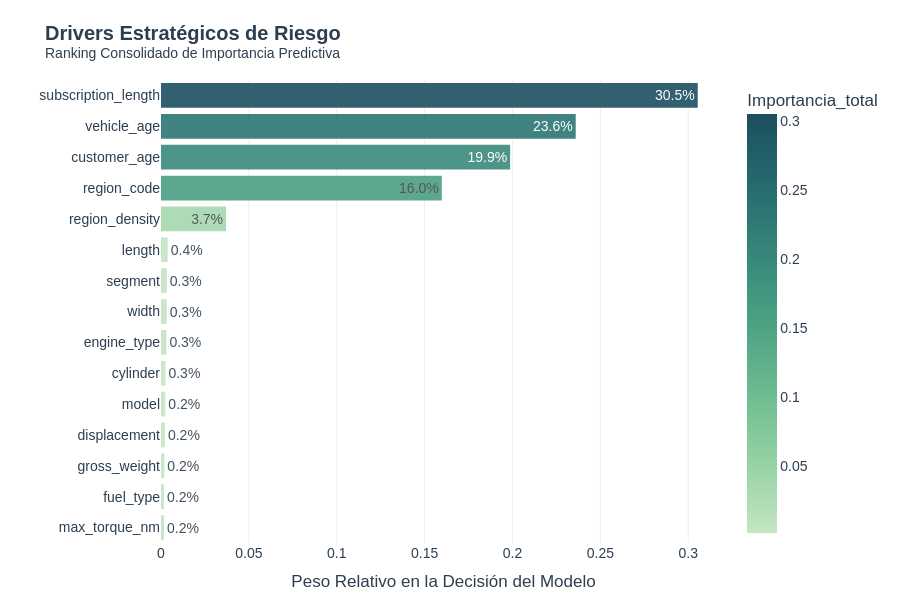

In [16]:
df_plot = df_permutation_results_final.head(15).copy()

# Ordenar inverso para que el Top 1 quede arriba en el eje Y
df_plot = df_plot.sort_values(by='Importancia_total', ascending=True)


fig = px.bar(
    df_plot,
    x='Importancia_total',
    y='Variable',
    orientation='h',
    text_auto='.1%',
    color='Importancia_total',
    color_continuous_scale='Blugrn',
    title='<b>Drivers Estratégicos de Riesgo</b><br><sup>Ranking Consolidado de Importancia Predictiva</sup>'
)

# Personalización
fig.update_layout(
    plot_bgcolor='white',
    font=dict(family="Arial, sans-serif", size=14, color="#2c3e50"),
    showlegend=False,
    width=900,
    height=600,
    margin=dict(l=150, r=50, t=80, b=50),
    xaxis=dict(
        title="Peso Relativo en la Decisión del Modelo",
        showgrid=True,
        gridcolor='#ecf0f1',
        zeroline=False
    ),
    yaxis=dict(
        title="",
        showgrid=False
    )
)

# Mejorar las barras
fig.update_traces(
    marker_line_color='rgb(8,48,107)',
    marker_line_width=0,
    opacity=0.9,
    textposition='auto'
)

fig.show()

In [ ]:
df.to_csv("claim_dataset_transformed.csv")

En conjunto, los tres enfoques de importancia confirman que no existe una única variable dominante, sino un conjunto acotado de predictores moderadamente informativos liderados por subscription_length, vehicle_age, region code, region_density y customer_age, mientras que muchas variables técnicas de motor y dummies específicas aportan información marginal. Esta estructura de importancias es consistente con los hallazgos del EDA: la probabilidad de reclamo  con los datos existentes se explica mejor como combinación de duración de la relación, antigüedad del vehículo, contexto territorial y perfil del asegurado, más que por atributos mecánicos puntuales, lo que orienta el modelado posterior hacia interacciones entre estas dimensiones y justifica una reducción del espacio de features basada en el ranking consolidado.